In [1]:
import os
import getpass
from langchain import hub
from langchain.agents import create_openai_functions_agent
from langchain_openai.chat_models import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai.chat_models import AzureChatOpenAI
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langgraph.prebuilt.tool_executor import ToolExecutor
from langchain_core.agents import AgentAction, AgentFinish
from IPython.display import Image
from langchain_core.runnables.graph import CurveStyle, NodeColors, MermaidDrawMethod
from langgraph.graph import END, StateGraph


In [2]:
def initialize_llm(**kwargs):
    # initialize llm
    llm = AzureChatOpenAI(
        deployment_name=os.environ["AZURE_OPENAI_DEPLOYMENT"],
        api_key=os.environ["AZURE_OPENAI_API_KEY"],
        azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
        api_version=os.environ["AZURE_OPENAI_API_VERSION"],
        **kwargs
    )
    return llm

In [3]:
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
llm = initialize_llm(temperature=0.5, streaming=True)


In [5]:
from langchain_core.pydantic_v1 import BaseModel, Field
class SearchTool(BaseModel):
    """Look up things online, optionally returning directly"""
    query: str = Field(description="query to look up online")
    return_direct: bool = Field(
        description="whether or the result of this should be returned directly to the user without you seeing what it is",
        default=False
    )

In [6]:
search_tool = TavilySearchResults(max_results=1, args_schema=SearchTool)
tools = [search_tool]
tool_executor = ToolExecutor(tools=tools)

In [7]:
from langchain.tools.render import format_tool_to_openai_function
from langchain_core.utils.function_calling import convert_to_openai_function
functions = [convert_to_openai_function(tool) for tool in tools]
llm_with_tools = llm.bind_functions(functions)

In [8]:
p =llm_with_tools.invoke("what is the weather today in the United States")
p

In [9]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
    messages:Annotated[Sequence[BaseMessage],operator.add]
    

In [10]:
from langgraph.prebuilt import ToolInvocation
import json
from langchain_core.messages import FunctionMessage

In [12]:
def should_continue(state):
    messages =state['messages']
    last_message =  messages[-1]
    # if there is no function call then we finish
    if "function_call" not in last_message.additional_kwargs:
        return "end"
    else:
        arguments = json.loads(last_message.additional_kwargs["function_call"]["arguments"])
        if arguments.get("return_direct",False): # False here means that if return_direct is not present it will return False, and well go to continue
            return "final"
        else:
            return "continue"

In [13]:
def call_model(state):
    messages =state['messages']
    response =  llm_with_tools.invoke(messages)
    return {'messages':[response]}

In [16]:
def call_tool(state):
    messages = state['messages']
    # based on the continue condition
    # we know that the last message involves function call
    last_message =  messages[-1]
    
    # we construct a tool invocation from the function call
    tool_name = last_message.additional_kwargs["function_call"]["name"]
    arguments = json.loads(last_message.additional_kwargs["function_call"]["arguments"]) # same as tool input
    
    
    # agent is returning a value for return_direct but we dont want to pass it to the tool(since tool doesnt use this)
    # so we delete it if present before calling the tool
    if tool_name =="tavily_search_results_json":
        if "return_direct" in arguments:
            del arguments["return_direct"]
    action = ToolInvocation(tool =tool_name, tool_input =arguments,)
    response  = tool_executor.invoke(action)
    function_message = FunctionMessage(content = str(response),name = action.tool)
    return {'messages':[function_message]}

In [17]:
workflow = StateGraph(AgentState)

# create nodes
workflow.add_node("agent",call_model)
workflow.add_node("action",call_tool)
workflow.add_node("final",call_tool)

workflow.set_entry_point("agent")

# add conditional edge
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {"continue":"action",
     "final":"final",
    "end":END
    }
)

# add a normal edge
# because we always want to go to the agent after going to the action
workflow.add_edge("action","agent")
workflow.add_edge("final",END)

app = workflow.compile()

In [18]:
app.get_graph().print_ascii()


                    +-----------+                   
                    | __start__ |                   
                    +-----------+                   
                          *                         
                          *                         
                          *                         
                      +-------+                     
                      | agent |                     
                      +-------+***                  
                   ***            ****              
                  *                   ***           
                **                       ***        
    +-----------------+                     **      
    | should_continue |                      *      
    +-----------------+****                  *      
         *         **      ******            *      
       **            *           *****       *      
      *               **              ***    *      
+-------+               *               +-----

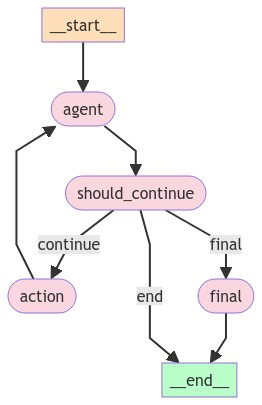

In [19]:
Image(app.get_graph().draw_mermaid_png(
    draw_method=MermaidDrawMethod.API,
))

In [20]:
from langchain_core.messages import HumanMessage
inputs  = {"messages":[HumanMessage(content="what is the weather in sf")]}
for output in app.stream(inputs):
    for key,value in output.items():
        print(f"output from node {key}")
        print("--------------------------------")
        print(value)
        print("--------------------------------")

output from node agent
--------------------------------
{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{\n  "query": "weather in San Francisco"\n}', 'name': 'tavily_search_results_json'}}, response_metadata={'finish_reason': 'function_call'}, id='run-298a8ce1-cafc-4014-9de2-776eb7b8b78a-0')]}
--------------------------------
output from node action
--------------------------------
{'messages': [FunctionMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'San Francisco\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\': 37.78, \'lon\': -122.42, \'tz_id\': \'America/Los_Angeles\', \'localtime_epoch\': 1713649201, \'localtime\': \'2024-04-20 14:40\'}, \'current\': {\'last_updated_epoch\': 1713648600, \'last_updated\': \'2024-04-20 14:30\', \'temp_c\': 17.8, \'temp_f\': 64.0, \'is_day\': 1, \'condition\': {\'text\': \'Sunny\', \'icon\': \'//cdn.weatherapi.com/weather/64x

In [21]:
inputs  = {"messages":[HumanMessage(content="what is the weather in sf, return the results directly by setting return_direct=true")]}
for output in app.stream(inputs):
    for key,value in output.items():
        print(f"output from node {key}")
        print("--------------------------------")
        print(value)
        print("--------------------------------")

output from node agent
--------------------------------
{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{\n  "query": "weather in San Francisco",\n  "return_direct": true\n}', 'name': 'tavily_search_results_json'}}, response_metadata={'finish_reason': 'function_call'}, id='run-1e871f12-b576-4949-9e2f-c58a8fd05375-0')]}
--------------------------------
output from node final
--------------------------------
{'messages': [FunctionMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'San Francisco\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\': 37.78, \'lon\': -122.42, \'tz_id\': \'America/Los_Angeles\', \'localtime_epoch\': 1713649201, \'localtime\': \'2024-04-20 14:40\'}, \'current\': {\'last_updated_epoch\': 1713648600, \'last_updated\': \'2024-04-20 14:30\', \'temp_c\': 17.8, \'temp_f\': 64.0, \'is_day\': 1, \'condition\': {\'text\': \'Sunny\', \'icon\': \'//cdn.w